### Задание 7 (2 балла)
Вам предлагается реализовать алгоритм аппроксимации функции синус с помощью метода [МНК](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2)

$$f(x)=sin(x), x \in [-180, 180]$$

* Вам необходимо будет аппроксимировать функцию на этом отрезке.
* Сформировать обучающее и тестовое множества самостоятельно.
* Использовать готовую реализацию из numpy в пунктах 1 и 2 - нельзя.
* Оценку времени выполнять из 10 запусков.
* При построении графиков, вам необходимо учитывать все 10 запусков (отразить дисперсию, "график с трубой")
* Кроссвалидацию делать необязательно
* Помните про радианы и градусы


In [35]:
import numpy as np
import scipy.stats as sps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.3)

#### 0. Создайте данные для решения задачи (0,1)

In [36]:
n_iter = 10
data = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
random_state = 42
# приближаем полиномом 4 степени
X = np.hstack((np.ones_like(data), data, data**2, data**3, data**4))
y = np.sin(data.reshape(-1))

#### 1. Реализуйте МНК с помощью numpy (0,2)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

In [37]:
%%time
approx = []

for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state + i
    )
    
    # МНК-оценка в линейной регрессии
    theta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
    pred = X @ theta
    approx.append(pred)
    
approx = np.array(approx)

Wall time: 7.98 ms


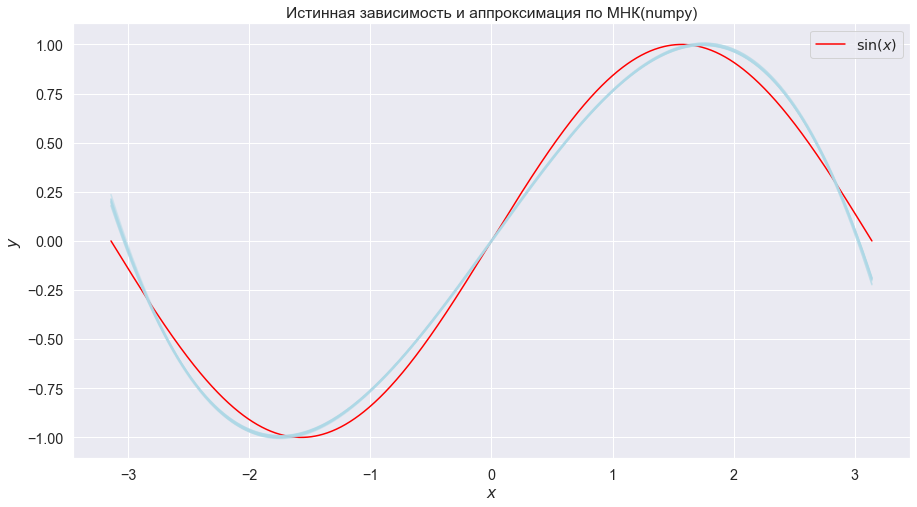

In [38]:
x_grid = data.reshape(-1)
plt.figure(figsize=(15, 8))
plt.plot(x_grid, y, label='$\\sin(x)$', color='red')
# на график наносятся все 10 предсказаний, но они близки друг к другу
plt.plot(data, approx.T, color='lightblue', alpha=0.5)
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Истинная зависимость и аппроксимация по МНК(numpy)')
plt.show()

#### 2. Реализуйте МНК с помощью numpy и cdef (0,3)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

Достаточно реализовать матричное умножение и обращение матрицы.

In [39]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [40]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython

def mm(np.ndarray A, np.ndarray B):
#     cdef list C
#     C = [[0 for col in range(B.shape[1])] for row in range(A.shape[0])]
    cdef np.ndarray C
    C = np.zeros((A.shape[0], B.shape[1]), dtype=A.dtype)
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(B.shape[0]):
                C[i][j] += A[i][k]*B[k][j]
    return C

In [41]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython

def inv(np.ndarray A):
    cdef int n = A.shape[0]
    cdef np.ndarray AM = np.copy(A)
    cdef np.ndarray I = np.eye(n)
    cdef np.ndarray IM = np.copy(I)
    cdef float fdScaler
    cdef float crScaler
 
    cdef list indices = list(range(n)) 
    for fd in np.arange(n): 
        fdScaler = 1.0 / AM[fd][fd]
        for j in np.arange(n):
            AM[fd][j] *= fdScaler
            IM[fd][j] *= fdScaler
        for i in indices[0:fd] + indices[fd+1:]: 
            crScaler = AM[i][fd]
            for j in np.arange(n): 
                AM[i][j] = AM[i][j] - crScaler * AM[fd][j]
                IM[i][j] = IM[i][j] - crScaler * IM[fd][j]
 
    return IM

In [42]:
%%time

approx = []


for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state + i
    )
    y_train = y_train.reshape(-1, 1)

    # МНК-оценка в линейной регрессии
    theta = mm(mm(inv(mm(X_train.T, X_train)), X_train.T), y_train)
    pred = mm(X, theta).reshape(-1)
    approx.append(pred)
    
approx = np.array(approx)

Wall time: 311 ms


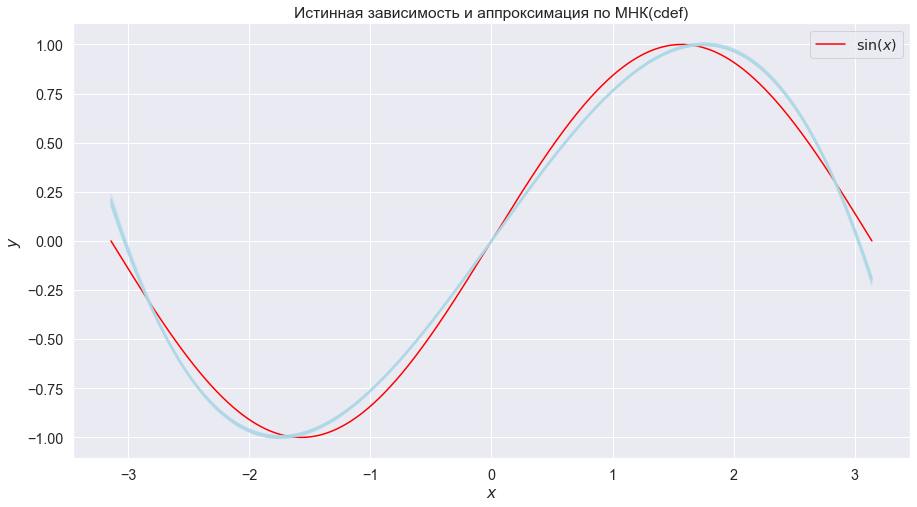

In [43]:
x_grid = data.reshape(-1)
plt.figure(figsize=(15, 8))
plt.plot(x_grid, y, label='$\\sin(x)$', color='red')
plt.plot(data, approx.T, color='lightblue', alpha=0.5)
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Истинная зависимость и аппроксимация по МНК(cdef)')
plt.show()

#### 3. Реализуйте МНК с помощью c extensions (0,4)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

#### 4. Сравните время работы (0,1)
Сравните время работы реализаций из пунктов "1. Реализуйте МНК с помощью numpy", "2. Реализуйте МНК с помощью numpy и cdef" и "3. Реализуйте МНК с помощью c extensions"

На чистом `numpy`: около 7 ms. На `numpy` с `cdef`: около 300 ms.

#### 5. Сделайте выводы по полученным оценкам времени (0,3):
В частности, ответить на вопросы:
1. Увеличилось ли время при использовании cdef в сравнении с numpy? - Почему? **(0,1)**
2. Как влияет c extensions на производительность? **(0,1)**
3. Сравните c extensions и вашу numpy реализацию. **(0,1)**

Реализация с помощью `cdef` явно проигрывает реализации на чистом `numpy`. Это связано с тем, что вызовы функций в `numpy` транслируются в код на C или Fortran, причём это делается со всевозможными оптимизациями. Кроме того, в подходе с `cdef` матричное умножение реализовано наивно с кубической временной сложностью, в то время как оптимальные алгоритмы имеют меньшую асимптотическую временную сложность. 

Реализация на `numpy`, вероятно, будет эффективнее наивной реализации через `extensions` из-за оптимизаций.

#### 6. Сделайте профилирование (0,4)
1. Сделайте профилирование реализации из пункта 1, можно ли как-то ускорить? **(0,2)**
1. Сделайте профилирование реализации из пункта 2, можно ли как-то ускорить? **(0,2)**

In [44]:
import cProfile, pstats, io
from pstats import SortKey

def profile(func):
    def wrapper(*args, **kwargs):
        pr = cProfile.Profile()
        pr.enable()
        result = func(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = SortKey.CUMULATIVE
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        
        return result
    return wrapper

# для измерения времени работы самой функции вынесем часть с разделением
# на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state
    )

In [45]:
@profile
def test_numpy_impl(X_train, y_train, X, n_iter=10):
    approx = []
    for i in range(n_iter):
        # МНК-оценка в линейной регрессии
        theta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train
        pred = X @ theta
        approx.append(pred)

    approx = np.array(approx)
    

In [46]:
test_numpy_impl(X_train, y_train, X)

         223 function calls in 0.002 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <ipython-input-45-4d49259e4c09>:1(test_numpy_impl)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(inv)
       10    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       10    0.000    0.000    0.000    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:482(inv)
       10    0.000    0.000    0.000    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:144(_commonType)
       10    0.000    0.000    0.000    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:116(_makearray)
       11    0.000    0.000    0.000    0.000 {built-in method numpy.array}
       10    0.000    0.000    0.000    0.000 {method 'astype

Можем наблюдать что время работы понизилось до 2 ms, даже несмотря на расходы, связанные с профилированием. Это означает, что на самом деле довольно много времени тратится на `train_test_split`, однако его в любом случае нужно выполнять по условию задачи. 

Время работы становится слишком маленьким, чтобы делать выводы о распределении процессорного времени, поэтому увеличим число итераций.

In [47]:
test_numpy_impl(X_train, y_train, X, n_iter=1000)

         22003 function calls in 0.061 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.037    0.037    0.061    0.061 <ipython-input-45-4d49259e4c09>:1(test_numpy_impl)
     1000    0.001    0.000    0.019    0.000 <__array_function__ internals>:2(inv)
     1000    0.001    0.000    0.018    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
     1000    0.008    0.000    0.017    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:482(inv)
     1001    0.005    0.000    0.005    0.000 {built-in method numpy.array}
     1000    0.002    0.000    0.003    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:144(_commonType)
     1000    0.001    0.000    0.002    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\linalg\linalg.py:116(_makearray)
     1000    0.001    0.000    0.001    0.000 {method 'asty

Как видим, обращение матрицы занимает больше всего времени(в сумме около $\frac23$ всего времени, так как в профилировании есть 2 вызова функций, отвечающих за обращение матриц -- inv). На втором месте идёт перемножение матриц(по-видимому, это `built-in method numpy.core._multiarray_umath.implement_array_function` в таблице профилирования) с $\frac13$ времени. Кажется, что эту реализацию уже нельзя оптимизировать, так как уже используются быстрые функции из `numpy`, и они же занимают большую часть времени. Сократить число вызовов функций тоже не получится, так как используется теоретическое точное решение задачи МНК.

In [48]:
@profile
def test_cdef_impl(X_train, y_train, X, n_iter=10):
    approx = []
    y_train = y_train.reshape(-1, 1)

    for i in range(n_iter):
        # МНК-оценка в линейной регрессии
        theta = mm(mm(inv(mm(X_train.T, X_train)), X_train.T), y_train)
        pred = mm(X, theta).reshape(-1)
        approx.append(pred)

    approx = np.array(approx)
    

In [50]:
test_cdef_impl(X_train, y_train, X, n_iter=100)

         1904 function calls in 3.247 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    3.247    3.247 <ipython-input-48-47c42238fea7>:1(test_cdef_impl)
      400    3.200    0.008    3.200    0.008 {_cython_magic_826a4b3831dd591e551c8f8180e3fc01.mm}
      100    0.040    0.000    0.044    0.000 {_cython_magic_2114460604c6527928b32918be671d21.inv}
      200    0.000    0.000    0.002    0.000 <__array_function__ internals>:2(copy)
      200    0.000    0.000    0.002    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      201    0.002    0.000    0.002    0.000 {built-in method numpy.array}
      100    0.001    0.000    0.002    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\lib\twodim_base.py:154(eye)
      200    0.000    0.000    0.001    0.000 C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\numpy\lib\function_base.py:730(copy)
    

Здесь больше всего времени(около 99%) тратится на матричное умножение. Действительно, обращение матриц происходит только один раз в каждой итерации, и матрица имеет размер $5\times5$, поэтому на эти операции тратится относительно мало времени в данном случае. Напротив, операций перемножения встречается довольно много, и они реализованы наивно. Кроме того, что они имеют кубическую сложность по времени, так ещё и неэффективно используется кеш процессора: в одной матрице мы двигаемся по строке(кеш-френдли), а в другой -- по столбцу(много кеш-миссов). Для оптимизации времени работы в данном подходе надо в первую очередь обратить внимание на матричное умножение.

#### 7. Используйте готовую реализацию МНК из numpy / scipy (0,1)
Протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию.

In [55]:
%%time
approx = []

for i in range(n_iter):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.5,
        random_state=random_state + i
    )
    
    # numpy-реализация МНК
    theta = np.linalg.lstsq(X_train, y_train)[0]
    pred = X @ theta
    approx.append(pred)
    
approx = np.array(approx)

Wall time: 11 ms


C:\Users\Q\Anaconda2\envs\mipt-stats\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


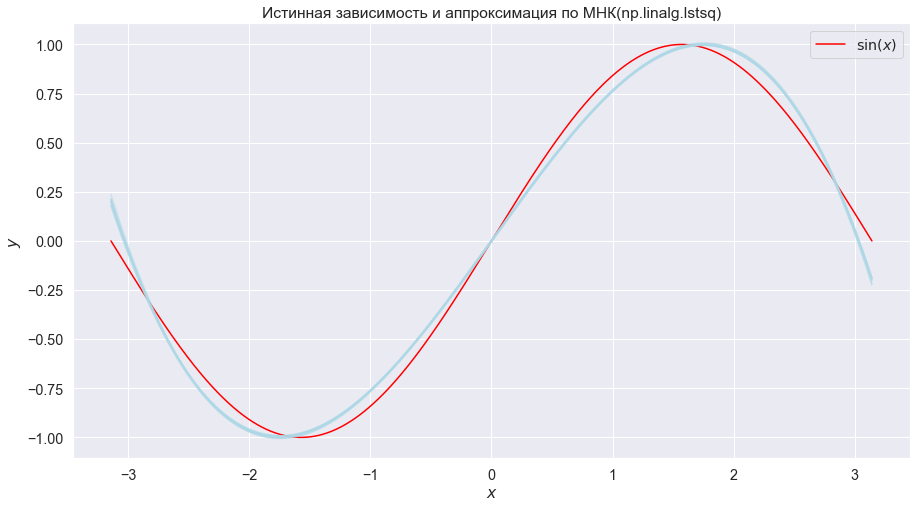

In [57]:
x_grid = data.reshape(-1)
plt.figure(figsize=(15, 8))
plt.plot(x_grid, y, label='$\\sin(x)$', color='red')
plt.plot(data, approx.T, color='lightblue', alpha=0.5)
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Истинная зависимость и аппроксимация по МНК(np.linalg.lstsq)')
plt.show()

Этот метод немного уступает в эффективности реализации на чистом `numpy`. Возможно, так происходит потому, что внутри метода вычисляются дополнительные значения(например, сингулярные числа), а также происходит проверка на обратимость матрицы, чего нет в первой реализации.

#### 8. Выводы (0,1)
Резюмируйте и сделайте выводы относительно проведенных экспериментов

Все рассмотренные методы показали одинаковый результат с точки зрения качества приближения, ведь везде используется по сути одна и та же формула. Однако, методы различаются по производительности. Самой быстрой оказалась реализация на чистом `numpy`, затем, с небольшим отставанием, -- `numpy.linalg.lstsq` и далее -- метод с cdef с большим разрывом. Предположительно, реализация с помощью extensions будет на одном уровне по скорости с cdef-реализацией, может быть, чуть быстрее.